#Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Import Library

In [2]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from PIL import Image
from google.colab import files
from pathlib import Path
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image

# encode both columns label and variety
from sklearn.preprocessing import LabelEncoder
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Setting up Data Generators for Augmentation and Validation

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range=40,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             validation_split=0.2)

val_datagen = ImageDataGenerator(rescale = 1./255,
                                validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
train_ds = train_datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Bangkit 2024/Capstone Bangkit/ML Task/Model V9.2/dataset_v2/train',
    batch_size = 32,
    target_size = (224, 224),
    class_mode='categorical',
    subset="training",
    seed=123
)

validation_ds = val_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Bangkit 2024/Capstone Bangkit/ML Task/Model V9.2/dataset_v2/train',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    subset="validation",
    seed=123
)


test_ds = train_datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Bangkit 2024/Capstone Bangkit/ML Task/Model V9.2/dataset_v2/test_mixed',
    batch_size = 32,
    target_size = (224, 224),
    class_mode='categorical'
)

Found 1720 images belonging to 30 classes.
Found 422 images belonging to 30 classes.
Found 426 images belonging to 30 classes.


# Visualize The Images

In [5]:
def visualize_images(path, num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image
        image_path = os.path.join(path, image_filename)
        image = plt.imread(image_path)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

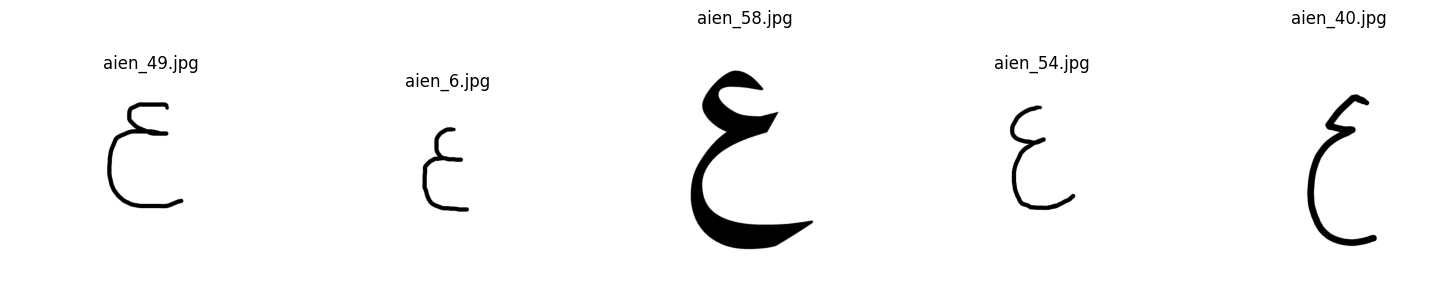

In [6]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/Bangkit 2024/Capstone Bangkit/ML Task/Model V9.2/dataset_v2/train/ain"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

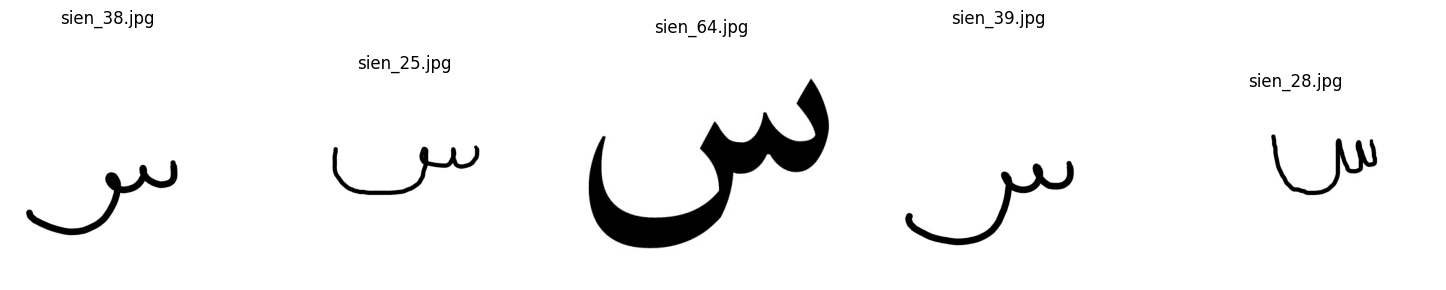

In [7]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/Bangkit 2024/Capstone Bangkit/ML Task/Model V9.2/dataset_v2/train/sin"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

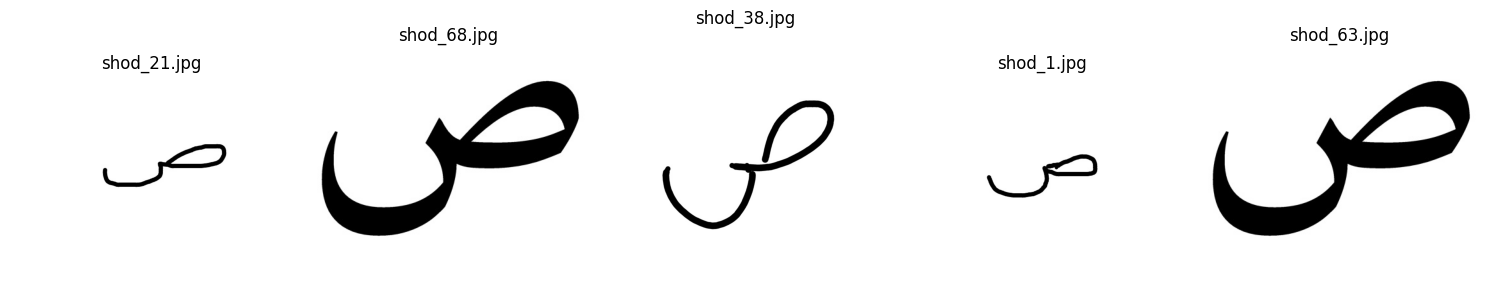

In [8]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/Bangkit 2024/Capstone Bangkit/ML Task/Model V9.2/dataset_v2/train/shod"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# Training Model

In [9]:
# Load the pre-trained MobileNetV2 base model
MobileNetV2_base = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Create input layer
inputs = Input(shape=(224, 224, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
# Add the pre-trained MobileNetV2 base model
x = MobileNetV2_base(inputs, training=False)

# Flatten the output
x = Flatten()(x)

# Add a dense layer with 512 units and ReLU activation function
x = Dense(512, activation='relu')(x)

# Add Dropout layer with 0.4 dropout rate
x = Dropout(0.4)(x)

# Add the output layer with 30 units and softmax activation function for multi-class classification
outputs = Dense(30, activation='softmax')(x)

# Create the model
model = Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 512)               32113152  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 30)                15390     
                                                             

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
 loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss') < 0.1 and logs.get('val_loss') < 0.1):
      print("\Stop, Akurasi mencapai target")
      self.model.stop_training = True;

mycallback = myCallback()

In [14]:
%%time
# # Define the callback function
early_stopping = EarlyStopping(patience=10)

history= model.fit(train_ds,
    validation_data=validation_ds,
    steps_per_epoch=len(train_ds),
    epochs=50,
    callbacks=[early_stopping, mycallback]
)

Epoch 1/50
54/54 [==============================] - 796s 14s/step - loss: 2.4379 - accuracy: 0.3110 - val_loss: 0.8466 - val_accuracy: 0.7275
Epoch 2/50
54/54 [==============================] - 337s 6s/step - loss: 0.7367 - accuracy: 0.7669 - val_loss: 0.4468 - val_accuracy: 0.8436
Epoch 3/50
54/54 [==============================] - 343s 6s/step - loss: 0.3680 - accuracy: 0.8849 - val_loss: 0.2774 - val_accuracy: 0.8981
Epoch 4/50
54/54 [==============================] - 325s 6s/step - loss: 0.2362 - accuracy: 0.9285 - val_loss: 0.2762 - val_accuracy: 0.8957
Epoch 5/50
54/54 [==============================] - 331s 6s/step - loss: 0.1624 - accuracy: 0.9506 - val_loss: 0.1152 - val_accuracy: 0.9621
Epoch 6/50
54/54 [==============================] - 377s 7s/step - loss: 0.1256 - accuracy: 0.9587 - val_loss: 0.1672 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 346s 6s/step - loss: 0.1612 - accuracy: 0.9523 - val_loss: 0.1326 - val_accuracy: 0.9573
Epoch 8/50
5

# Evaluate The Model

In [15]:
loss = model.evaluate(validation_ds)

14/14 [==============================] - 17s 1s/step - loss: 0.0255 - accuracy: 0.9882


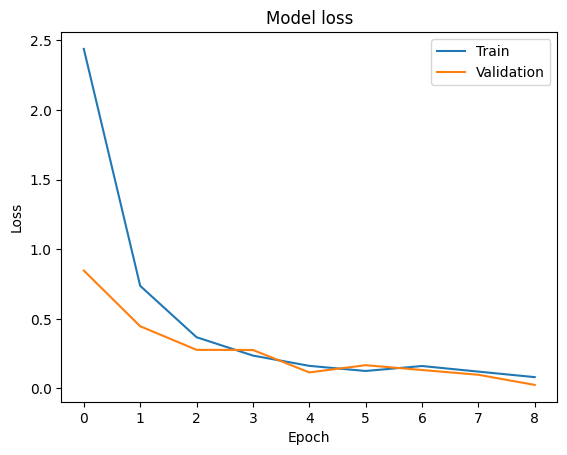

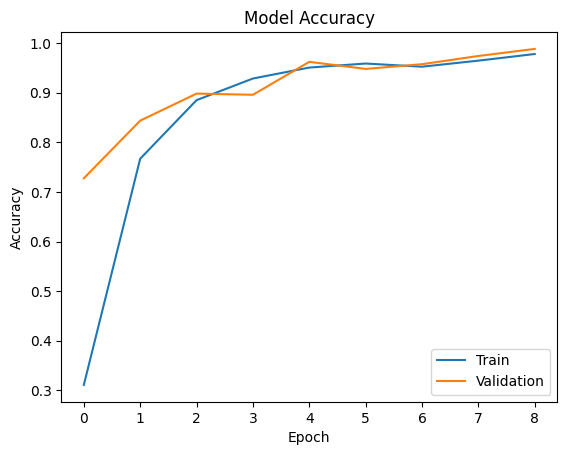

In [19]:
# Plotting the training and testing loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Get The Class Labels

1/1 [==============================] - 1s 964ms/step


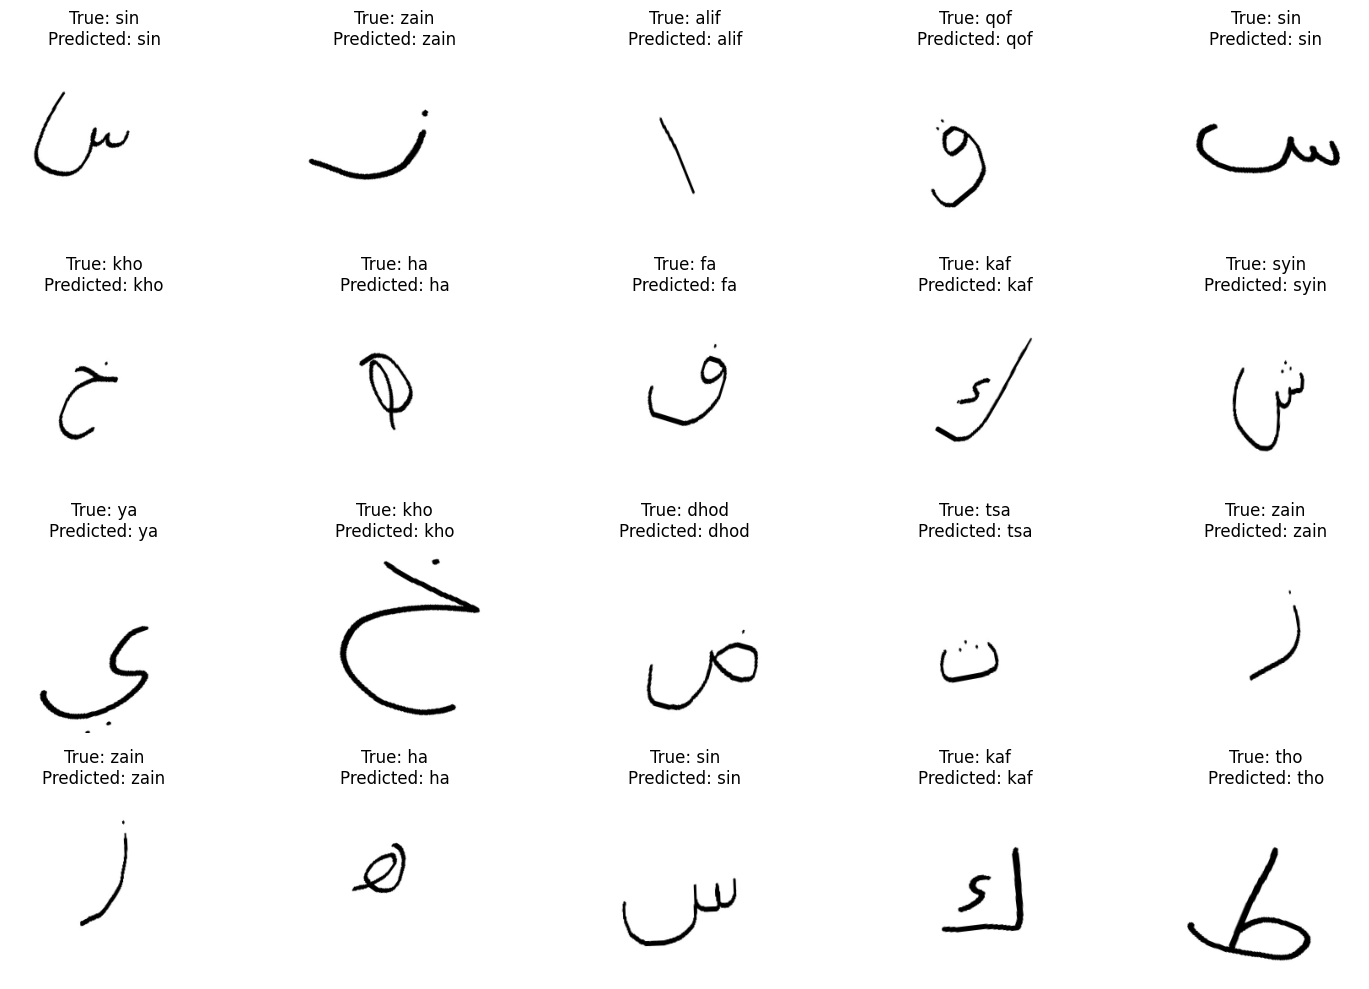

In [20]:
class_labels = list(test_ds.class_indices.keys())

# Predict on each image and plot results
num_images = 20
num_images_per_row = 5  # Set the number of images per row
num_rows = 4

plt.figure(figsize=(15, 10))
for i in range(num_images):
    image, label = next(test_ds)
    predictions = model.predict(image)

    # Iterate over each image in the batch
    for j in range(len(image)):
        if i * len(image) + j < num_images:  # Check if the total number of images exceeds the desired count
            predicted_class = class_labels[np.argmax(predictions[j])]
            true_class = class_labels[np.argmax(label[j])]

            plt.subplot(num_rows, num_images_per_row, i * len(image) + j + 1)
            plt.imshow(image[j])
            plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
            plt.axis('off')

plt.tight_layout()
plt.show()

# Saving Model

In [21]:
# Save the model to an H5 file
model.save('/content/drive/MyDrive/Bangkit 2024/Capstone Bangkit/ML Task/Model V9.2/Models 9.2/final_model_mm_v9_20.h5')

# Convert the model to TensorFlow Lite format
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Bangkit 2024/Capstone Bangkit/ML Task/Model V9.2/Models 9.2/final_model_mm_v9_20.h5')

# Convert the model to the TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('/content/drive/MyDrive/Bangkit 2024/Capstone Bangkit/ML Task/Model V9.2/Models 9.2/final_model_mm_v9_20.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model has been successfully converted to TensorFlow Lite format and saved as model.tflite")


Model has been successfully converted to TensorFlow Lite format and saved as model.tflite


# Uji Coba Model

In [22]:
MODEL_PATH = "/content/drive/MyDrive/Bangkit 2024/Capstone Bangkit/ML Task/Model V9.2/Models 9.2/final_model_mm_v9_20.h5"
data_path = '/content/drive/MyDrive/Bangkit 2024/Capstone Bangkit/ML Task/Model V9.2/dataset_v2/train'
final_model = tf.keras.models.load_model(MODEL_PATH)
print(f"Model loaded from {MODEL_PATH}")

Model loaded from /content/drive/MyDrive/Bangkit 2024/Capstone Bangkit/ML Task/Model V9.2/Models 9.2/final_model_mm_v9_20.h5


In [27]:
# Fungsi preprocess image
def preprocess_image_as_array(image_path, show_output=True):
    im = Image.open(image_path).convert('RGB')
    im = im.resize((224, 224))

    if show_output:
        plt.figure(figsize=(8, 8))
        plt.imshow(im)
        plt.axis('off')
        plt.show()

    return np.asarray(im)

def predict_image_class(model, img_array, class_names, threshold=0.7):
    img_batch = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_batch)[0]

    predicted_class_index = np.argmax(predictions)
    predicted_class_score = predictions[predicted_class_index]
    predicted_class = class_names[predicted_class_index]

    if predicted_class_score >= threshold:
        print(f"\nPredicted class: {predicted_class} (confidence: {predicted_class_score:.4f})")
        for idx, score in enumerate(predictions):
            print(f"{class_names[idx]}: {score:.4f}")
        return predicted_class
    else:
        print("\nInvalid Image.")
        return None

Saving gha8.jpg to gha8.jpg

Processing Image: gha8.jpg


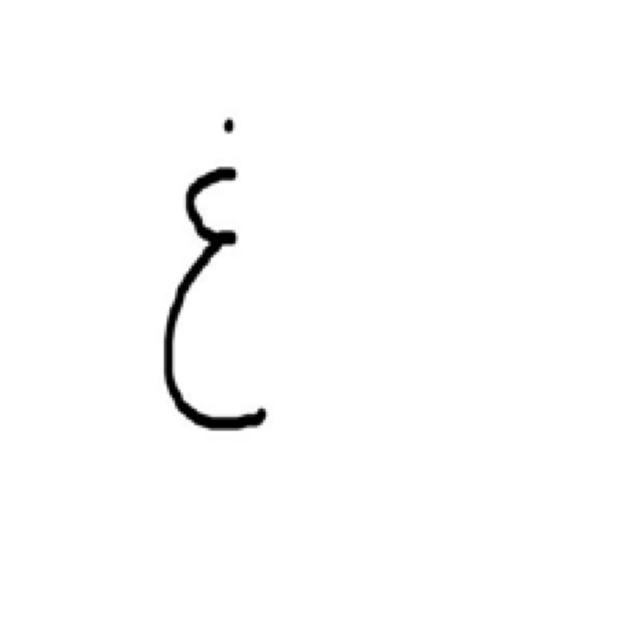

1/1 [==============================] - 0s 66ms/step

Predicted class: ghoin (confidence: 0.8071)
ain: 0.0298
alif: 0.0012
ba: 0.0009
dal: 0.0013
dhod: 0.0168
dzal: 0.0107
dzho: 0.0025
fa: 0.0138
ghoin: 0.8071
ha: 0.0049
ha_: 0.0029
hamzah: 0.0027
jim: 0.0077
kaf: 0.0118
kho: 0.0042
lam: 0.0044
lamalif: 0.0014
mim: 0.0084
nun: 0.0117
qof: 0.0171
ro: 0.0006
shod: 0.0006
sin: 0.0048
syin: 0.0087
ta: 0.0005
tho: 0.0013
tsa: 0.0066
wawu: 0.0053
ya: 0.0026
zain: 0.0075


In [33]:
# Upload and Predict Image Function
def upload_and_predict_image(model, class_names, threshold=0.5):
    uploaded = files.upload()
    for image_name in uploaded.keys():
        print(f"\nProcessing Image: {image_name}")
        img_array = preprocess_image_as_array(image_name)
        predicted_class = predict_image_class(model, img_array, class_names, threshold)
        # if predicted_class is not None:
        #     print(f"Predicted Class for Image {image_name}: {predicted_class}")
        # else:
        #     print(f"Failed to Predict Class for Image {image_name}")

# Fetching class names from the training dataset
class_names = sorted(os.listdir(data_path))

# Calling a function to upload and predict an image
upload_and_predict_image(final_model, class_names, threshold=0.7)